# Text-to-Speech with TorchAudio

## Preparation

In [2]:
# !pip3 install deep_phonemizer
# !pip3 install torchaudio

In [3]:
import torch
import torchaudio
import matplotlib.pyplot as plt

import IPython
print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

1.11.0
0.11.0


## Text Processing

### Character-based encoding

In this section, we will go through how tohe character-based encoding works.

Since the pre-trained Tacotron2 model expects specific set of symbol tables, the same functionalities available in `torchaudio`. This section is more for the explanation of the basis of encoding.

Firstly, we define the set of symbols. For example, we can use `'_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'`. Then, we will map each character of the input text into the index of the corresponding symbol in the table.

The following is an example of such processing. In the example, symbols that are not in the table are ignored.

In [4]:
symbols = '_-!\'(),.:;? abcdefghijklmnopqrstuvwxyz'
look_up = {s: i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

text = "Hello world! Text to speech!"
print(text_to_sequence(text))

[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]


In [5]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


The `processor` object takes either a text or list of texts as inputs. When a list of texts are provided, the returned `lengths` variable represents the valid length of each processed tokens in the output batch.

The intermediate representation can be retrieved as follows:

In [6]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


### Phoneme-based encoding

Phoneme-based encoding is similar to character-based encoding, but it uses a symbol table based on phhonemes and a G2P (Grapheme-to-Phoneme) model.

The detail of the G2P model is out of scope of this tutorial, we will just look at what the conversion looks like.

Similar to the case of character-based encoding, the encoding process is expected to match what a pretrained Tacotron2 model is trained on. `torchaudio` has an interface to create the process.

The following code illustrates how to make and use the process. Behind the scene, a G2P model is created using `DeepPhonemizer` package, and the pretrained weights published by the author of `DeepPhonemizer` is fetched.

In [7]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()

text = "Hello world! Text to speech!"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])
tensor([25], dtype=torch.int32)


Notice that the encoded values are different from the example of character-based encoding.

The intermediate representation looks like the following.

In [8]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


### Spectrogram Generation

`Tacotron2` is the model we use to generate spectrogram from the encoded text. For the detail of the model, please refer to [the paper](https://arxiv.org/abs/1712.05884).

It is easy to instantiate a Tacotron2 model with pretrained weight, however, note that the input to Tacotron2 models are processed by the matching text processor.

`torchaudio` bundles the matching models and processors together so that it is easy to create the pipeline.

(For the available bundles, and its usage, please refer to [the documentation](https://pytorch.org/audio/stable/pipelines.html#tacotron2-text-to-speech).)

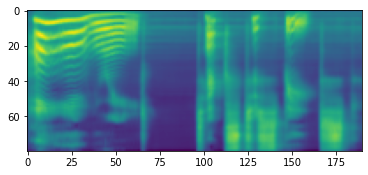

In [9]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)

plt.imshow(spec[0].cpu().detach())

Note that `Tacotron2.infer` method performs multinomial sampling, therefor, the process of generating the spectrogram incurs randomness.

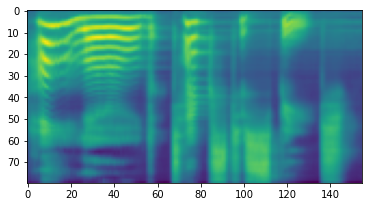

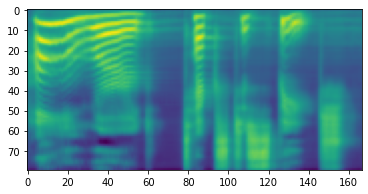

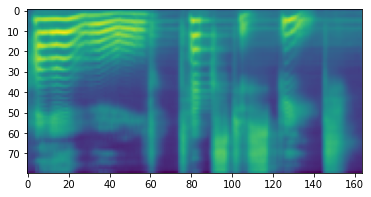

In [10]:
for _ in range(3):
    with torch.inference_mode():
        spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    plt.imshow(spec[0].cpu().detach())
    plt.show()